# A Matching Theory Framework for Tasks Offloading in Fog Computing for IoT Systems

Insights: 

Each Edge Device submits only one task, because the number of tasks is equal to the number of Edge Devices.

Each Task has a preference for Fog Nodes, and each Fog Node has a preference for Tasks, and we have to match these as best as we can.



## Procedure:

1. First each Edge Device has a neighbour discovery phase where it finds the communication cost to each Fog Node. This part can be randomly generated as a matrix of size n x f. CHECK THIS DIMENSION TO MAKE SURE IT MAKES SENSE IN LINEAR ALGEBRA. We also need to generate the array of time that Task j takes at Fog Node i. 

2. The objective functions we use to decide preference orders of FN for Tasks and Task for FNs, both have a "waiting time that task j has to suffer before being processed, if offloaded to FN i at time C". Here, I think they're just saying: 

    * The current time is C,
    * The task is sent to FN i at this time, but FN i is busy
    * We expect the Task to be processed as soon as FN is free again, but it might just get offloaded again.

  Hence we just need to find how much more time FN i needs to stop executing all its tasks. Since all tasks are done in parallel, we just need to find the longest task it's currently doing. Alternatively, we can also take an option with shortest task that it is currently doing, and assume that the new task gets put in as soon as the shortest job gets completed, but that's a bit more complicated. 

3. Then a modified Deferred Acceptance Algorithm is performed to get a preliminary match M<sub>1</sub>

4. 






## IMPORTS

In [ ]:
import random
random.seed(119)
import scipy
from scipy.stats import poisson
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## ALL GLOBAL VARIABLES

In [ ]:
CIRCLE_RADIUS = 100 #metres
N_TASKS = random.randint(100, 1000)
N_FOG_NODES = 5
N_TASK_TYPES = 15

## Getting the positions of each Fog Node and Edge Device.

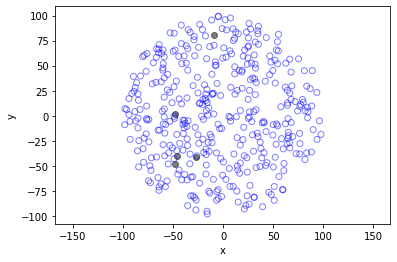

In [ ]:
#Simulation window parameters
Radius = 100 # SHOULD BE 100 but took too long to run
xx0=0; yy0=0; #centre of disk

areaTotal=np.pi*Radius**2; #area of disk


#Point process parameters

lambda0=0; #intensity (ie mean density) of the Poisson process
numbPoints = 0
while(numbPoints < N_TASKS + N_FOG_NODES+2):
  numbPoints = scipy.stats.poisson( lambda0*areaTotal ).rvs()#Poisson number of points
  lambda0 = lambda0 + 0.001

theta = 2*np.pi*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))#angular coordinates of Poisson points
rho = Radius*np.sqrt(scipy.stats.uniform.rvs(0,1,((numbPoints,1))))#radial coordinates of Poisson points

#Convert from polar to Cartesian coordinates
xx = rho * np.cos(theta)
yy = rho * np.sin(theta)

#Shift centre of disk to (xx0,yy0) 
xx=xx+xx0; yy=yy+yy0;

[fog_nodes_x, edge_devices_x, _] = np.split(xx,[N_FOG_NODES, N_FOG_NODES+N_TASKS]) 
[fog_nodes_y, edge_devices_y, _] = np.split(yy,[N_FOG_NODES, N_FOG_NODES+N_TASKS])

#Plotting
plt.scatter(fog_nodes_x,fog_nodes_y, edgecolor='black', facecolor='black', alpha=0.5 )
plt.scatter(edge_devices_x,edge_devices_y, edgecolor='b', facecolor='none', alpha=0.5 )

plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal')


assert(len(edge_devices_x) == N_TASKS)
assert(len(fog_nodes_x) == N_FOG_NODES)

# Proposed Algorithm



## Calculate communication costs

In [ ]:
E_communication_costs = []
for i in range(fog_nodes_x.shape[0]):
  distances = []
  for j in range(edge_devices_x.shape[0]):
    p1 = [fog_nodes_x[i][0],fog_nodes_y[i][0]]
    p2 = [edge_devices_x[j][0],edge_devices_y[j][0]]
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    distances.append(distance)
  E_communication_costs.append(distances)

## Get the Task Execution Speeds

In [ ]:
processor_speeds = {1: 0.0000000002778,2: 0.0000000003704, 3: 0.0000000004167, 4: 0.0000000005263, 5: 0.00000000035714}

processors = [] 
for i in range(fog_nodes_x.shape[0]):
  processors.append(processor_speeds[random.randint(1,5)])
processors = np.array(processors)
print(processors)

[3.7040e-10 3.5714e-10 3.5714e-10 5.2630e-10 2.7780e-10]


In [ ]:
instructions = []
for i in range(edge_devices_x.shape[0]):
  instructions.append(random.randint(10000,50000))

In [ ]:
time_to_execute = [] # (j, i), Time taken to execute task i at FN j.
for i in range(fog_nodes_x.shape[0]):
  times = []
  for j in range(edge_devices_x.shape[0]):
    times.append(instructions[j]*processors[i])
  time_to_execute.append(times)
time_to_execute = np.array(time_to_execute)
print(time_to_execute)

max_exec_time = []
for temp in time_to_execute:
  max_exec_time.append(np.sum(temp))

max_exec_time = np.max(max_exec_time)
print(f"MAX Possible time - {max_exec_time}")

[[5.62859840e-06 1.40952016e-05 9.61039840e-06 ... 1.43381840e-05
  1.74591744e-05 1.72887904e-05]
 [5.42709944e-06 1.35906056e-05 9.26635444e-06 ... 1.38248894e-05
  1.68341510e-05 1.66698666e-05]
 [5.42709944e-06 1.35906056e-05 9.26635444e-06 ... 1.38248894e-05
  1.68341510e-05 1.66698666e-05]
 [7.99765480e-06 2.00278202e-05 1.36553798e-05 ... 2.03730730e-05
  2.48076768e-05 2.45655788e-05]
 [4.22144880e-06 1.05714012e-05 7.20779880e-06 ... 1.07536380e-05
  1.30943808e-05 1.29665928e-05]]
MAX Possible time - 0.0061624024908000005


## Creating waiting times

In [ ]:
waiting_times = np.zeros((edge_devices_x.shape[0],fog_nodes_x.shape[0]))
# For each task i, the waiting time at 
# fog node j is initially zero (i, j)
# List of lists, tells how much time task i has to wait before proposing to FN j again. (i, j)
# WAITING TIMES is the time on GLOBAL CLOCK! It isn't the total time till when the FN j is free!!

## Create ED's preference list

In [ ]:
ED_preference_list = []
for j in range(edge_devices_x.shape[0]):
  ed_preferencs = []
  for i in range(fog_nodes_x.shape[0]):
    ed_preferencs.append(1/(E_communication_costs[i][j]+10_000_000*waiting_times[j][i]))
  ED_preference_list.append(ed_preferencs)

## Create FN's preference list

In [ ]:
FN_preference_list = []
for i in range(fog_nodes_x.shape[0]):
  fn_preferencs = []
  for j in range(edge_devices_x.shape[0]):
    fn_preferencs.append(1/(E_communication_costs[i][j]+10_000_000*waiting_times[j][i]+10_000_000*time_to_execute[i][j]))
  FN_preference_list.append(fn_preferencs)

## Create Fog node max limits

In [ ]:
max_limits = []
for i in range(N_FOG_NODES):
  max_limits.append(random.randint(2,10))

In [ ]:
# ALL TASKS HAVE INDICES IN i
# ALL FOG NODES HAVE INDICES IN j

TOTAL_TASKS = N_TASKS
TASKS_COMPLETED = 0
GLOBAL_CLOCK = 0
allocated = {} # Dictionary to tell if a task has been allocated
COMPLETION_TIME = dict() # Dictionary to track completion time.
TIME_SPENT_WAITING = dict()

for i in range(N_TASKS):
  allocated[i] = False
ALLOCATED_TASKS = [] #List of lists, tells which tasks have been allocated to FN j. (j, i) is a tuple of (task id, clock time of completion)
PROPOSAL_QUEUES = [] # List of lists, tells which tasks have proposed to FN j. (j, i) 

RESULTS_AVG_WAIT_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK STARTS GETTING EXECUTED, MARK THIS WITH GLOBAL CLOCK
RESULTS_AVG_EXEC_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK FINISHES, MARK THIS WITH GLOBAL CLOCK

for j in range(N_FOG_NODES):
  ALLOCATED_TASKS.append([])
  PROPOSAL_QUEUES.append([])
  
iters = 0 
while TASKS_COMPLETED < TOTAL_TASKS:
  # print(f"{TOTAL_TASKS - TASKS_COMPLETED} tasks remaining")
  
  # DISCARD COMPLETED TASKS
  for i in range(N_FOG_NODES):
    allocated_tasks = ALLOCATED_TASKS[i].copy()
    for task in allocated_tasks:
        if(task[0] <= GLOBAL_CLOCK):
          TASKS_COMPLETED=TASKS_COMPLETED+1
          COMPLETION_TIME[task[1]]= GLOBAL_CLOCK
          ALLOCATED_TASKS[i].remove(task)
  
  # Add proposals ## ADDING PROPOSALS SHOULD BE DONE FROM AN EDGE DEVICE ONLY 
  ## AFTER ITS WAITING TIME FOR THAT FN HAS PASSED!
  for i in range(N_TASKS):
    # i <- Index of task/Edge Device
    if allocated[i] == True: # If the task has already been allocated, it means it's in processing rn.
      continue

    best_preference = (-1,-1) # (ed_preference, fog_node number) initialize the best preference
    for j in range(N_FOG_NODES):
    # j <- Index of Fog Node.
      if len(ALLOCATED_TASKS[j]) == max_limits[j]: # If Ki tasks have been fully assigned to FN j, then skip because it's not going to replace any existing tasks
        continue
      elif(ED_preference_list[i][j] > best_preference[0]):
        # print(f"")
        best_preference = (ED_preference_list[i][j],j)
    # Pushing to the best preference's proposal queue
    if(best_preference != (-1,-1)):
      PROPOSAL_QUEUES[best_preference[1]].append((FN_preference_list[best_preference[1]][i],i)) # Adding proposal to preference queue

  for j in range(N_FOG_NODES):
    # Find all proposals and accept them in higest preference order 
    # (https://www.delftstack.com/howto/python/sort-list-by-another-list-python/)
    PROPOSAL_QUEUES[j] = sorted(PROPOSAL_QUEUES[j], reverse=True)
    # x is the Ki value, minus number of allocated tasks, giving total free slots.
    X = max_limits[j] - len(ALLOCATED_TASKS[j])
    # Accept x tasks from the PROPOSAL_QUEUES[j]
    # print(f"{max_limits[j]} - {len(ALLOCATED_TASKS[j])}")
    total_proposals = len(PROPOSAL_QUEUES[j])
    for x in range(min(X,total_proposals)):
      ALLOCATED_TASKS[j].append((GLOBAL_CLOCK+time_to_execute[j][PROPOSAL_QUEUES[j][0][1]],PROPOSAL_QUEUES[j][0][1]))
      allocated[PROPOSAL_QUEUES[j][0][1]] = True
      TIME_SPENT_WAITING[PROPOSAL_QUEUES[j][0][1]]=GLOBAL_CLOCK # Setting time spent waiting.
      PROPOSAL_QUEUES[j].pop(0)
    PROPOSAL_QUEUES[j] = []
  
  # Updating waiting times
  # for each Fog Node,
  for j in range(N_FOG_NODES):
    # Calculate time remaining for all tasks at FN j,
    waiting_time = []

    # The min value of this will be the time till when another slot opens.
    for i in range(len(ALLOCATED_TASKS[j])):
      #Calculate waiting time
      waiting_time.append(ALLOCATED_TASKS[j][i][0]-GLOBAL_CLOCK)

    #Assign waiting time
    if len(waiting_time):
      waiting_time = min(waiting_time) 
    else:
      waiting_time = 0.0

    # Go through all unallocated tasks, and send them the waiting time
    # needed to resubmit a task to that node.
    for i in range(N_TASKS):
      if(allocated[i]==False):
        waiting_times[i][j] = waiting_time


  # Update preference lists
  # for each Fog Node:
  FN_preference_list = []
  for j in range(N_FOG_NODES):
    fn_preferencs = []
    for i in range(N_TASKS):
      # Update the preference with waiting time in the denominator
      fn_preferencs.append(1/(E_communication_costs[j][i]+10_000_000*waiting_times[i][j]+10_000_000*time_to_execute[j][i]))
    FN_preference_list.append(fn_preferencs)

    

    
  # for each Edge Device:
  ED_preference_list = []
  for i in range(N_TASKS):
    ed_preferencs = []
    for j in range(N_FOG_NODES):
      ed_preferencs.append(1/(E_communication_costs[j][i]+10_000_000*waiting_times[i][j]))
    ED_preference_list.append(ed_preferencs)
  
  # Increment Time
  all_fog_nodes_busy = True
  for j in range(N_FOG_NODES):
    if len(ALLOCATED_TASKS[j])==max_limits[j]:
      continue
    else:
      all_fog_nodes_busy = False
      break

  all_tasks_allocated = True
  for i in range(N_FOG_NODES):
     if(allocated[i]==False):
       all_tasks_allocated = False
       break

  if all_fog_nodes_busy:
    GLOBAL_CLOCK += 0.000001
  elif all_tasks_allocated:
    GLOBAL_CLOCK += 0.000001

  # print(f"{TOTAL_TASKS - TASKS_COMPLETED} Tasks left")
  # print(f"GLOBAL CLOCK IS {GLOBAL_CLOCK}")
  # If all FN capacities (max_limits) are filled, then increment the counter.
  # Else, let it loop.

      
    
  
    
# print(f"Average time for execution = {np.average(COMPLETION_TIME.values())}")


In [ ]:
print(f"PREDICTED MAX Possible time - {max_exec_time}")
print(f"GLOBAL CLOCK AT END OF EXECUTION - {GLOBAL_CLOCK}")
completion_times = list(COMPLETION_TIME.values())
print(f"Average time to completion - {np.average(completion_times)}")
print(len(TIME_SPENT_WAITING.keys()))
# wait_times = completion_times - list(TIME_SPENT_WAITING.values())
# print(f"Average waiting times - {np.average(wait_times)}")

PREDICTED MAX Possible time - 0.0061624024908000005
GLOBAL CLOCK AT END OF EXECUTION - 0.00018699999999999959
Average time to completion - 7.88520408163264e-05
392


# Greedy - Nearest Offload Algorithm 

Find the nearest Fog Node and offload the tasks to that FN. The paper itself doesn't specify what to do if the FN is busy! So we'll implement two variants: one where the order is fixed, and it'll keep pinging the same FN until it gets accepted, another where it keeps pinging different FNs each time it gets rejected from one.

In [ ]:
FN_preference_list = []
for i in range(fog_nodes_x.shape[0]):
  fn_preferencs = []
  for j in range(edge_devices_x.shape[0]):
    fn_preferencs.append(1/(E_communication_costs[i][j]))
  FN_preference_list.append(fn_preferencs)


ED_preference_list = []
for j in range(edge_devices_x.shape[0]):
  ed_preferencs = []
  for i in range(fog_nodes_x.shape[0]):
    ed_preferencs.append(1/(E_communication_costs[i][j]))
  ED_preference_list.append(ed_preferencs)


# ALL TASKS HAVE INDICES IN i
# ALL FOG NODES HAVE INDICES IN j

TOTAL_TASKS = N_TASKS
TASKS_COMPLETED = 0
GLOBAL_CLOCK = 0
allocated = {} # Dictionary to tell if a task has been allocated
COMPLETION_TIME = dict() # Dictionary to track completion time.
TIME_SPENT_WAITING = dict()

for i in range(N_TASKS):
  allocated[i] = False
ALLOCATED_TASKS = [] #List of lists, tells which tasks have been allocated to FN j. (j, i) is a tuple of (task id, clock time of completion)
PROPOSAL_QUEUES = [] # List of lists, tells which tasks have proposed to FN j. (j, i) 

RESULTS_AVG_WAIT_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK STARTS GETTING EXECUTED, MARK THIS WITH GLOBAL CLOCK
RESULTS_AVG_EXEC_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK FINISHES, MARK THIS WITH GLOBAL CLOCK

for j in range(N_FOG_NODES):
  ALLOCATED_TASKS.append([])
  PROPOSAL_QUEUES.append([])
  
iters = 0 
while TASKS_COMPLETED < TOTAL_TASKS:
  
  # DISCARD COMPLETED TASKS
  for i in range(N_FOG_NODES):
    allocated_tasks = ALLOCATED_TASKS[i].copy()
    for task in allocated_tasks:
        if(task[0] <= GLOBAL_CLOCK):
          TASKS_COMPLETED=TASKS_COMPLETED+1
          COMPLETION_TIME[task[1]]= GLOBAL_CLOCK
          ALLOCATED_TASKS[i].remove(task)
  
  # Add proposals ## ADDING PROPOSALS SHOULD BE DONE FROM AN EDGE DEVICE ONLY 
  ## AFTER ITS WAITING TIME FOR THAT FN HAS PASSED!
  for i in range(N_TASKS):
    # i <- Index of task/Edge Device
    if allocated[i] == True: # If the task has already been allocated, it means it's in processing rn.
      continue

    best_preference = (-1,-1) # (ed_preference, fog_node number) initialize the best preference
    for j in range(N_FOG_NODES):
    # j <- Index of Fog Node.
      if len(ALLOCATED_TASKS[j]) == max_limits[j]: # If Ki tasks have been fully assigned to FN j, then skip because it's not going to replace any existing tasks
        continue
      elif(ED_preference_list[i][j] > best_preference[0]):
        # print(f"")
        best_preference = (ED_preference_list[i][j],j)
    # Pushing to the best preference's proposal queue
    if(best_preference != (-1,-1)):
      PROPOSAL_QUEUES[best_preference[1]].append((FN_preference_list[best_preference[1]][i],i)) # Adding proposal to preference queue

  for j in range(N_FOG_NODES):
    PROPOSAL_QUEUES[j] = sorted(PROPOSAL_QUEUES[j], reverse=True)
    X = max_limits[j] - len(ALLOCATED_TASKS[j])
    total_proposals = len(PROPOSAL_QUEUES[j])
    for x in range(min(X,total_proposals)):
      ALLOCATED_TASKS[j].append((GLOBAL_CLOCK+time_to_execute[j][PROPOSAL_QUEUES[j][0][1]],PROPOSAL_QUEUES[j][0][1]))
      allocated[PROPOSAL_QUEUES[j][0][1]] = True
      TIME_SPENT_WAITING[PROPOSAL_QUEUES[j][0][1]]=GLOBAL_CLOCK 
      PROPOSAL_QUEUES[j].pop(0)
    PROPOSAL_QUEUES[j] = []
  
  # Updating waiting times
  # for each Fog Node,
  for j in range(N_FOG_NODES):
    # Calculate time remaining for all tasks at FN j,
    waiting_time = []

    # The min value of this will be the time till when another slot opens.
    for i in range(len(ALLOCATED_TASKS[j])):
      #Calculate waiting time
      waiting_time.append(ALLOCATED_TASKS[j][i][0]-GLOBAL_CLOCK)

    #Assign waiting time
    if len(waiting_time):
      waiting_time = min(waiting_time) 
    else:
      waiting_time = 0.0

    # Go through all unallocated tasks, and send them the waiting time
    # needed to resubmit a task to that node.
    for i in range(N_TASKS):
      if(allocated[i]==False):
        waiting_times[i][j] = waiting_time


  # Update preference lists
  # for each Fog Node:
  FN_preference_list = []
  for j in range(N_FOG_NODES):
    fn_preferencs = []
    for i in range(N_TASKS):
      # Update the preference with waiting time in the denominator
      fn_preferencs.append(1/(E_communication_costs[j][i]))
    FN_preference_list.append(fn_preferencs)

    

    
  # for each Edge Device:
  ED_preference_list = []
  for i in range(N_TASKS):
    ed_preferencs = []
    for j in range(N_FOG_NODES):
      ed_preferencs.append(1/(E_communication_costs[j][i]))
    ED_preference_list.append(ed_preferencs)
  
  # Increment Time
  all_fog_nodes_busy = True
  for j in range(N_FOG_NODES):
    if len(ALLOCATED_TASKS[j])==max_limits[j]:
      continue
    else:
      all_fog_nodes_busy = False
      break

  all_tasks_allocated = True
  for i in range(N_FOG_NODES):
     if(allocated[i]==False):
       all_tasks_allocated = False
       break

  if all_fog_nodes_busy:
    GLOBAL_CLOCK += 0.000001
  elif all_tasks_allocated:
    GLOBAL_CLOCK += 0.000001

  # print(f"{TOTAL_TASKS - TASKS_COMPLETED} Tasks left")
  # print(f"GLOBAL CLOCK IS {GLOBAL_CLOCK}")
  # If all FN capacities (max_limits) are filled, then increment the counter.
  # Else, let it loop.

      
    
  
    
# print(f"Average time for execution = {np.average(COMPLETION_TIME.values())}")


In [ ]:
print(f"PREDICTED MAX Possible time - {max_exec_time}")
print(f"GLOBAL CLOCK AT END OF EXECUTION - {GLOBAL_CLOCK}")
completion_times = list(COMPLETION_TIME.values())
print(f"Average time to completion - {np.average(completion_times)}")
print(len(TIME_SPENT_WAITING.keys()))
# wait_times = completion_times - list(TIME_SPENT_WAITING.values())
# print(f"Average waiting times - {np.average(wait_times)}")

PREDICTED MAX Possible time - 0.0061624024908000005
GLOBAL CLOCK AT END OF EXECUTION - 0.00019499999999999956
Average time to completion - 9.376530612244881e-05
392


# Randomised Offload Algorithm

Find a random FN, and send task there. Again, the paper doesn't specify how it handles busy FNs! So we'll do the same two variants, where it keeps pinging once and then waits, another where it re-rolls if it finds the FN is busy.

In [ ]:
# ALL TASKS HAVE INDICES IN i
# ALL FOG NODES HAVE INDICES IN j

ED_preference_list = []
for j in range(edge_devices_x.shape[0]):
  ed_preferencs = list(range(1,N_FOG_NODES+1))
  random.shuffle(ed_preferencs)
  ED_preference_list.append(ed_preferencs)

FN_preference_list = []
for i in range(fog_nodes_x.shape[0]):
  fn_preferencs = list(range(1,N_TASKS+1))
  random.shuffle(fn_preferencs)
  FN_preference_list.append(fn_preferencs)

print(len(ED_preference_list))
print(len(ED_preference_list[0]))

# ALL TASKS HAVE INDICES IN i
# ALL FOG NODES HAVE INDICES IN j

TOTAL_TASKS = N_TASKS
TASKS_COMPLETED = 0
GLOBAL_CLOCK = 0
allocated = {} # Dictionary to tell if a task has been allocated
COMPLETION_TIME = dict() # Dictionary to track completion time.
TIME_SPENT_WAITING = dict()

for i in range(N_TASKS):
  allocated[i] = False
ALLOCATED_TASKS = [] #List of lists, tells which tasks have been allocated to FN j. (j, i) is a tuple of (task id, clock time of completion)
PROPOSAL_QUEUES = [] # List of lists, tells which tasks have proposed to FN j. (j, i) 

RESULTS_AVG_WAIT_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK STARTS GETTING EXECUTED, MARK THIS WITH GLOBAL CLOCK
RESULTS_AVG_EXEC_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK FINISHES, MARK THIS WITH GLOBAL CLOCK

for j in range(N_FOG_NODES):
  ALLOCATED_TASKS.append([])
  PROPOSAL_QUEUES.append([])
  
iters = 0 
while TASKS_COMPLETED < TOTAL_TASKS:
  
  # DISCARD COMPLETED TASKS
  for i in range(N_FOG_NODES):
    allocated_tasks = ALLOCATED_TASKS[i].copy()
    for task in allocated_tasks:
        if(task[0] <= GLOBAL_CLOCK):
          TASKS_COMPLETED=TASKS_COMPLETED+1
          COMPLETION_TIME[task[1]]= GLOBAL_CLOCK
          ALLOCATED_TASKS[i].remove(task)
  
  # Add proposals ## ADDING PROPOSALS SHOULD BE DONE FROM AN EDGE DEVICE ONLY 
  ## AFTER ITS WAITING TIME FOR THAT FN HAS PASSED!
  for i in range(N_TASKS):
    # i <- Index of task/Edge Device
    if allocated[i] == True: # If the task has already been allocated, it means it's in processing rn.
      continue

    best_preference = (-1,-1) # (ed_preference, fog_node number) initialize the best preference
    for j in range(N_FOG_NODES):
    # j <- Index of Fog Node.
      if len(ALLOCATED_TASKS[j]) == max_limits[j]: # If Ki tasks have been fully assigned to FN j, then skip because it's not going to replace any existing tasks
        continue
      elif(ED_preference_list[i][j] > best_preference[0]):
        # print(f"")
        best_preference = (ED_preference_list[i][j],j)
    # Pushing to the best preference's proposal queue
    if(best_preference != (-1,-1)):
      PROPOSAL_QUEUES[best_preference[1]].append((FN_preference_list[best_preference[1]][i],i)) # Adding proposal to preference queue

  for j in range(N_FOG_NODES):
    PROPOSAL_QUEUES[j] = sorted(PROPOSAL_QUEUES[j], reverse=True)
    X = max_limits[j] - len(ALLOCATED_TASKS[j])
    total_proposals = len(PROPOSAL_QUEUES[j])
    for x in range(min(X,total_proposals)):
      ALLOCATED_TASKS[j].append((GLOBAL_CLOCK+time_to_execute[j][PROPOSAL_QUEUES[j][0][1]],PROPOSAL_QUEUES[j][0][1]))
      allocated[PROPOSAL_QUEUES[j][0][1]] = True
      TIME_SPENT_WAITING[PROPOSAL_QUEUES[j][0][1]]=GLOBAL_CLOCK 
      PROPOSAL_QUEUES[j].pop(0)
    PROPOSAL_QUEUES[j] = []
  
  # Updating waiting times
  # for each Fog Node,
  for j in range(N_FOG_NODES):
    # Calculate time remaining for all tasks at FN j,
    waiting_time = []

    # The min value of this will be the time till when another slot opens.
    for i in range(len(ALLOCATED_TASKS[j])):
      #Calculate waiting time
      waiting_time.append(ALLOCATED_TASKS[j][i][0]-GLOBAL_CLOCK)

    #Assign waiting time
    if len(waiting_time):
      waiting_time = min(waiting_time) 
    else:
      waiting_time = 0.0

    # Go through all unallocated tasks, and send them the waiting time
    # needed to resubmit a task to that node.
    for i in range(N_TASKS):
      if(allocated[i]==False):
        waiting_times[i][j] = waiting_time


  # Update preference lists
  # for each Fog Node:
  ED_preference_list = []
  for j in range(edge_devices_x.shape[0]):
    ed_preferencs = list(range(1,N_FOG_NODES+1))
    random.shuffle(ed_preferencs)
    ED_preference_list.append(ed_preferencs)

  FN_preference_list = []
  for i in range(fog_nodes_x.shape[0]):
    fn_preferencs = list(range(1,N_TASKS+1))
    random.shuffle(fn_preferencs)
    FN_preference_list.append(fn_preferencs)
  
  # Increment Time
  all_fog_nodes_busy = True
  for j in range(N_FOG_NODES):
    if len(ALLOCATED_TASKS[j])==max_limits[j]:
      continue
    else:
      all_fog_nodes_busy = False
      break

  all_tasks_allocated = True
  for i in range(N_FOG_NODES):
     if(allocated[i]==False):
       all_tasks_allocated = False
       break

  if all_fog_nodes_busy:
    GLOBAL_CLOCK += 0.000001
  elif all_tasks_allocated:
    GLOBAL_CLOCK += 0.000001



392
5


In [ ]:
print(f"PREDICTED MAX Possible time - {max_exec_time}")
print(f"GLOBAL CLOCK AT END OF EXECUTION - {GLOBAL_CLOCK}")
completion_times = list(COMPLETION_TIME.values())
print(f"Average time to completion - {np.average(completion_times)}")
print(len(TIME_SPENT_WAITING.keys()))
# wait_times = completion_times - list(TIME_SPENT_WAITING.values())
# print(f"Average waiting times - {np.average(wait_times)}")

PREDICTED MAX Possible time - 0.0061624024908000005
GLOBAL CLOCK AT END OF EXECUTION - 0.00019199999999999957
Average time to completion - 9.544897959183657e-05
392


# METRICS

## Jain's Fairness Index

They say the JFI indicates "well balanced total completion time for all offloaded tasks". This means we'll take JFI on completion times.

## Worst Task Completion Time

Find the time from start to finish.

## Mean Waiting time

Find average of time from start of clock to start of execution, for every task.

## Mean Total Task Completion TIme

Find the average of time from start of clock to end of execution, for every task.


# Defining different functions for running each algorithm:

### Results variables:

In [ ]:
results = dict()
wait_results = dict()
jfi_results = dict()

def jfi(x):
  val = float(sum(x)**2)
  dr = float(len(x) * sum([a**2 for a in x]))
  

## Common parts

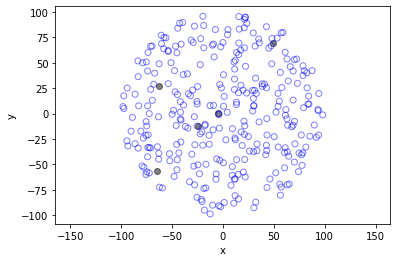

In [ ]:
CIRCLE_RADIUS = 100 #metres
# N_TASKS = random.randint(100, 1000)
N_TASKS = 300
N_FOG_NODES = 5
N_TASK_TYPES = 15

Radius = CIRCLE_RADIUS 
xx0=0; yy0=0; #centre of disk

areaTotal=np.pi*Radius**2; #area of disk


#Point process parameters

lambda0=0; #intensity (ie mean density) of the Poisson process
numbPoints = 0
while(numbPoints < N_TASKS + N_FOG_NODES+2):
  numbPoints = scipy.stats.poisson( lambda0*areaTotal ).rvs()#Poisson number of points
  lambda0 = lambda0 + 0.001

theta = 2*np.pi*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))#angular coordinates of Poisson points
rho = Radius*np.sqrt(scipy.stats.uniform.rvs(0,1,((numbPoints,1))))#radial coordinates of Poisson points

#Convert from polar to Cartesian coordinates
xx = rho * np.cos(theta)
yy = rho * np.sin(theta)

#Shift centre of disk to (xx0,yy0) 
xx=xx+xx0; yy=yy+yy0;

[fog_nodes_x, edge_devices_x, _] = np.split(xx,[N_FOG_NODES, N_FOG_NODES+N_TASKS]) 
[fog_nodes_y, edge_devices_y, _] = np.split(yy,[N_FOG_NODES, N_FOG_NODES+N_TASKS])

#Plotting
plt.scatter(fog_nodes_x,fog_nodes_y, edgecolor='black', facecolor='black', alpha=0.5 )
plt.scatter(edge_devices_x,edge_devices_y, edgecolor='b', facecolor='none', alpha=0.5 )

plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal')


E_communication_costs = []
for i in range(fog_nodes_x.shape[0]):
  distances = []
  for j in range(edge_devices_x.shape[0]):
    p1 = [fog_nodes_x[i][0],fog_nodes_y[i][0]]
    p2 = [edge_devices_x[j][0],edge_devices_y[j][0]]
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    distances.append(distance)
  E_communication_costs.append(distances)


processor_speeds = {1: 0.0000000002778,2: 0.0000000003704, 3: 0.0000000004167, 4: 0.0000000005263, 5: 0.00000000035714}

processors = [] 
for i in range(fog_nodes_x.shape[0]):
  processors.append(processor_speeds[random.randint(1,5)])
processors = np.array(processors)


instructions = []
for i in range(edge_devices_x.shape[0]):
  instructions.append(random.randint(10000,50000))


time_to_execute = [] # (j, i), Time taken to execute task i at FN j.
for i in range(fog_nodes_x.shape[0]):
  times = []
  for j in range(edge_devices_x.shape[0]):
    times.append(instructions[j]*processors[i])
  time_to_execute.append(times)
time_to_execute = np.array(time_to_execute)


max_exec_time = []
for temp in time_to_execute:
  max_exec_time.append(np.sum(temp))

max_exec_time = np.max(max_exec_time)
# print(f"MAX Possible time - {max_exec_time}")


waiting_times = np.zeros((edge_devices_x.shape[0],fog_nodes_x.shape[0]))

num_fog_nodes = fog_nodes_x.shape[0]
max_limits = []
for i in range(num_fog_nodes):
  max_limits.append(random.randint(2,10))

In [ ]:
print(f"Number of FNs - {N_FOG_NODES}\nNumber of Tasks - {N_TASKS}")

Number of FNs - 5
Number of Tasks - 300


## Proposed Algorithm

In [ ]:
TOTAL_TASKS = N_TASKS
TASKS_COMPLETED = 0
GLOBAL_CLOCK = 0
allocated = {} # Dictionary to tell if a task has been allocated
COMPLETION_TIME = dict() # Dictionary to track completion time.
TIME_SPENT_WAITING = dict()

for i in range(N_TASKS):
  allocated[i] = False
ALLOCATED_TASKS = [] #List of lists, tells which tasks have been allocated to FN j. (j, i) is a tuple of (task id, clock time of completion)
PROPOSAL_QUEUES = [] # List of lists, tells which tasks have proposed to FN j. (j, i) 

RESULTS_AVG_WAIT_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK STARTS GETTING EXECUTED, MARK THIS WITH GLOBAL CLOCK
RESULTS_AVG_EXEC_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK FINISHES, MARK THIS WITH GLOBAL CLOCK

for j in range(N_FOG_NODES):
  ALLOCATED_TASKS.append([])
  PROPOSAL_QUEUES.append([])

FN_preference_list = []
for j in range(N_FOG_NODES):
  fn_preferencs = []
  for i in range(N_TASKS):
    # Update the preference with waiting time in the denominator
    fn_preferencs.append(1/(E_communication_costs[j][i]+10_000_000*waiting_times[i][j]+10_000_000*time_to_execute[j][i]))
  FN_preference_list.append(fn_preferencs)

    
ED_preference_list = []
for i in range(N_TASKS):
  ed_preferencs = []
  for j in range(N_FOG_NODES):
    ed_preferencs.append(1/(E_communication_costs[j][i]+10_000_000*waiting_times[i][j]))
  ED_preference_list.append(ed_preferencs)


iters = 0 
while TASKS_COMPLETED < TOTAL_TASKS:
  # print(f"{TOTAL_TASKS - TASKS_COMPLETED} tasks remaining")
  
  # DISCARD COMPLETED TASKS
  for i in range(N_FOG_NODES):
    allocated_tasks = ALLOCATED_TASKS[i].copy()
    for task in allocated_tasks:
        if(task[0] <= GLOBAL_CLOCK):
          TASKS_COMPLETED=TASKS_COMPLETED+1
          COMPLETION_TIME[task[1]]= GLOBAL_CLOCK
          ALLOCATED_TASKS[i].remove(task)
  
  # Add proposals ## ADDING PROPOSALS SHOULD BE DONE FROM AN EDGE DEVICE ONLY 
  ## AFTER ITS WAITING TIME FOR THAT FN HAS PASSED!
  for i in range(N_TASKS):
    # i <- Index of task/Edge Device
    if allocated[i] == True: # If the task has already been allocated, it means it's in processing rn.
      continue

    best_preference = (-1,-1) # (ed_preference, fog_node number) initialize the best preference
    for j in range(N_FOG_NODES):
    # j <- Index of Fog Node.
      if len(ALLOCATED_TASKS[j]) == max_limits[j]: # If Ki tasks have been fully assigned to FN j, then skip because it's not going to replace any existing tasks
        continue
      elif(ED_preference_list[i][j] > best_preference[0]):
        # print(f"")
        best_preference = (ED_preference_list[i][j],j)
    # Pushing to the best preference's proposal queue
    if(best_preference != (-1,-1)):
      PROPOSAL_QUEUES[best_preference[1]].append((FN_preference_list[best_preference[1]][i],i)) # Adding proposal to preference queue

  for j in range(N_FOG_NODES):
    # Find all proposals and accept them in higest preference order 
    # (https://www.delftstack.com/howto/python/sort-list-by-another-list-python/)
    PROPOSAL_QUEUES[j] = sorted(PROPOSAL_QUEUES[j], reverse=True)
    # x is the Ki value, minus number of allocated tasks, giving total free slots.
    X = max_limits[j] - len(ALLOCATED_TASKS[j])
    # Accept x tasks from the PROPOSAL_QUEUES[j]
    # print(f"{max_limits[j]} - {len(ALLOCATED_TASKS[j])}")
    total_proposals = len(PROPOSAL_QUEUES[j])
    for x in range(min(X,total_proposals)):
      ALLOCATED_TASKS[j].append((GLOBAL_CLOCK+time_to_execute[j][PROPOSAL_QUEUES[j][0][1]],PROPOSAL_QUEUES[j][0][1]))
      allocated[PROPOSAL_QUEUES[j][0][1]] = True
      TIME_SPENT_WAITING[PROPOSAL_QUEUES[j][0][1]]=GLOBAL_CLOCK # Setting time spent waiting.
      PROPOSAL_QUEUES[j].pop(0)
    PROPOSAL_QUEUES[j] = []
  
  # Updating waiting times
  # for each Fog Node,
  for j in range(N_FOG_NODES):
    # Calculate time remaining for all tasks at FN j,
    waiting_time = []

    # The min value of this will be the time till when another slot opens.
    for i in range(len(ALLOCATED_TASKS[j])):
      #Calculate waiting time
      waiting_time.append(ALLOCATED_TASKS[j][i][0]-GLOBAL_CLOCK)

    #Assign waiting time
    if len(waiting_time):
      waiting_time = min(waiting_time) 
    else:
      waiting_time = 0.0

    # Go through all unallocated tasks, and send them the waiting time
    # needed to resubmit a task to that node.
    for i in range(N_TASKS):
      if(allocated[i]==False):
        waiting_times[i][j] = waiting_time


  # Update preference lists
  # for each Fog Node:
  FN_preference_list = []
  for j in range(N_FOG_NODES):
    fn_preferencs = []
    for i in range(N_TASKS):
      # Update the preference with waiting time in the denominator
      fn_preferencs.append(1/(E_communication_costs[j][i]+10_000_000*waiting_times[i][j]+10_000_000*time_to_execute[j][i]))
    FN_preference_list.append(fn_preferencs)

    
  # for each Edge Device:
  ED_preference_list = []
  for i in range(N_TASKS):
    ed_preferencs = []
    for j in range(N_FOG_NODES):
      ed_preferencs.append(1/(E_communication_costs[j][i]+10_000_000*waiting_times[i][j]))
    ED_preference_list.append(ed_preferencs)
  
  # Increment Time
  all_fog_nodes_busy = True
  for j in range(N_FOG_NODES):
    if len(ALLOCATED_TASKS[j])==max_limits[j]:
      continue
    else:
      all_fog_nodes_busy = False
      break

  all_tasks_allocated = True
  for i in range(N_FOG_NODES):
     if(allocated[i]==False):
       all_tasks_allocated = False
       break

  if all_fog_nodes_busy:
    GLOBAL_CLOCK += 0.000_000_5
  elif all_tasks_allocated:
    GLOBAL_CLOCK += 0.000_000_5

In [ ]:
print(f"PREDICTED MAX Possible time - {max_exec_time}")
print(f"GLOBAL CLOCK AT END OF EXECUTION - {GLOBAL_CLOCK}")
completion_times = list(COMPLETION_TIME.values())
print(f"Average time to completion - {np.average(completion_times)}")
time_of_waits = list(TIME_SPENT_WAITING.values())
print(f"Average wait time - {np.average(time_of_waits)}")
proposed_algo_stats = {
    'clock' : GLOBAL_CLOCK,
    'avg_comp_time' : np.average(completion_times),
    'avg_wait_time' : np.average(time_of_waits),
    'jain_data' : time_of_waits
}

PREDICTED MAX Possible time - 0.0038893623741
GLOBAL CLOCK AT END OF EXECUTION - 0.00012049999999999972
Average time to completion - 5.00349999999999e-05
Average wait time - 3.9623333333333256e-05


## Greedy Algorithm

In [ ]:
TOTAL_TASKS = N_TASKS
TASKS_COMPLETED = 0
GLOBAL_CLOCK = 0
allocated = {} # Dictionary to tell if a task has been allocated
COMPLETION_TIME = dict() # Dictionary to track completion time.
TIME_SPENT_WAITING = dict()

for i in range(N_TASKS):
  allocated[i] = False
ALLOCATED_TASKS = [] #List of lists, tells which tasks have been allocated to FN j. (j, i) is a tuple of (task id, clock time of completion)
PROPOSAL_QUEUES = [] # List of lists, tells which tasks have proposed to FN j. (j, i) 

RESULTS_AVG_WAIT_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK STARTS GETTING EXECUTED, MARK THIS WITH GLOBAL CLOCK
RESULTS_AVG_EXEC_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK FINISHES, MARK THIS WITH GLOBAL CLOCK

for j in range(N_FOG_NODES):
  ALLOCATED_TASKS.append([])
  PROPOSAL_QUEUES.append([])

FN_preference_list = []
for j in range(N_FOG_NODES):
  fn_preferencs = []
  for i in range(N_TASKS):
    # Update the preference with waiting time in the denominator
    fn_preferencs.append(1/(E_communication_costs[j][i]))
  FN_preference_list.append(fn_preferencs)

    
ED_preference_list = []
for i in range(N_TASKS):
  ed_preferencs = []
  for j in range(N_FOG_NODES):
    ed_preferencs.append(1/(E_communication_costs[j][i]))
  ED_preference_list.append(ed_preferencs)


iters = 0 
while TASKS_COMPLETED < TOTAL_TASKS:
  # print(f"{TOTAL_TASKS - TASKS_COMPLETED} tasks remaining")
  
  # DISCARD COMPLETED TASKS
  for i in range(N_FOG_NODES):
    allocated_tasks = ALLOCATED_TASKS[i].copy()
    for task in allocated_tasks:
        if(task[0] <= GLOBAL_CLOCK):
          TASKS_COMPLETED=TASKS_COMPLETED+1
          COMPLETION_TIME[task[1]]= GLOBAL_CLOCK
          ALLOCATED_TASKS[i].remove(task)
  
  # Add proposals ## ADDING PROPOSALS SHOULD BE DONE FROM AN EDGE DEVICE ONLY 
  ## AFTER ITS WAITING TIME FOR THAT FN HAS PASSED!
  for i in range(N_TASKS):
    # i <- Index of task/Edge Device
    if allocated[i] == True: # If the task has already been allocated, it means it's in processing rn.
      continue

    best_preference = (-1,-1) # (ed_preference, fog_node number) initialize the best preference
    for j in range(N_FOG_NODES):
    # j <- Index of Fog Node.
      if len(ALLOCATED_TASKS[j]) == max_limits[j]: # If Ki tasks have been fully assigned to FN j, then skip because it's not going to replace any existing tasks
        continue
      elif(ED_preference_list[i][j] > best_preference[0]):
        # print(f"")
        best_preference = (ED_preference_list[i][j],j)
    # Pushing to the best preference's proposal queue
    if(best_preference != (-1,-1)):
      PROPOSAL_QUEUES[best_preference[1]].append((FN_preference_list[best_preference[1]][i],i)) # Adding proposal to preference queue

  for j in range(N_FOG_NODES):
    # Find all proposals and accept them in higest preference order 
    # (https://www.delftstack.com/howto/python/sort-list-by-another-list-python/)
    PROPOSAL_QUEUES[j] = sorted(PROPOSAL_QUEUES[j], reverse=True)
    # x is the Ki value, minus number of allocated tasks, giving total free slots.
    X = max_limits[j] - len(ALLOCATED_TASKS[j])
    # Accept x tasks from the PROPOSAL_QUEUES[j]
    # print(f"{max_limits[j]} - {len(ALLOCATED_TASKS[j])}")
    total_proposals = len(PROPOSAL_QUEUES[j])
    for x in range(min(X,total_proposals)):
      ALLOCATED_TASKS[j].append((GLOBAL_CLOCK+time_to_execute[j][PROPOSAL_QUEUES[j][0][1]],PROPOSAL_QUEUES[j][0][1]))
      allocated[PROPOSAL_QUEUES[j][0][1]] = True
      TIME_SPENT_WAITING[PROPOSAL_QUEUES[j][0][1]]=GLOBAL_CLOCK # Setting time spent waiting.
      PROPOSAL_QUEUES[j].pop(0)
    PROPOSAL_QUEUES[j] = []
  
  # Updating waiting times
  # for each Fog Node,
  for j in range(N_FOG_NODES):
    # Calculate time remaining for all tasks at FN j,
    waiting_time = []

    # The min value of this will be the time till when another slot opens.
    for i in range(len(ALLOCATED_TASKS[j])):
      #Calculate waiting time
      waiting_time.append(ALLOCATED_TASKS[j][i][0]-GLOBAL_CLOCK)

    #Assign waiting time
    if len(waiting_time):
      waiting_time = min(waiting_time) 
    else:
      waiting_time = 0.0

    # Go through all unallocated tasks, and send them the waiting time
    # needed to resubmit a task to that node.
    for i in range(N_TASKS):
      if(allocated[i]==False):
        waiting_times[i][j] = waiting_time


  # Update preference lists
  # for each Fog Node:
  FN_preference_list = []
  for j in range(N_FOG_NODES):
    fn_preferencs = []
    for i in range(N_TASKS):
      # Update the preference with waiting time in the denominator
      fn_preferencs.append(1/(E_communication_costs[j][i]))
    FN_preference_list.append(fn_preferencs)

    
  # for each Edge Device:
  ED_preference_list = []
  for i in range(N_TASKS):
    ed_preferencs = []
    for j in range(N_FOG_NODES):
      ed_preferencs.append(1/(E_communication_costs[j][i]))
    ED_preference_list.append(ed_preferencs)
  
  # Increment Time
  all_fog_nodes_busy = True
  for j in range(N_FOG_NODES):
    if len(ALLOCATED_TASKS[j])==max_limits[j]:
      continue
    else:
      all_fog_nodes_busy = False
      break

  all_tasks_allocated = True
  for i in range(N_FOG_NODES):
     if(allocated[i]==False):
       all_tasks_allocated = False
       break

  if all_fog_nodes_busy:
    GLOBAL_CLOCK += 0.000_000_5
  elif all_tasks_allocated:
    GLOBAL_CLOCK += 0.000_000_5

In [ ]:
print(f"PREDICTED MAX Possible time - {max_exec_time}")
print(f"GLOBAL CLOCK AT END OF EXECUTION - {GLOBAL_CLOCK}")
completion_times = list(COMPLETION_TIME.values())
print(f"Average time to completion - {np.average(completion_times)}")
time_of_waits = list(TIME_SPENT_WAITING.values())
print(f"Average wait time - {np.average(time_of_waits)}")
ganc_stats = {
    'clock' : GLOBAL_CLOCK,
    'avg_comp_time' : np.average(completion_times),
    'avg_wait_time' : np.average(time_of_waits),
    'jain_data' : time_of_waits
}

PREDICTED MAX Possible time - 0.0038893623741
GLOBAL CLOCK AT END OF EXECUTION - 0.00012149999999999971
Average time to completion - 5.847499999999987e-05
Average wait time - 4.806833333333324e-05


## Randmomized Algorithm

In [ ]:
# ALL TASKS HAVE INDICES IN i
# ALL FOG NODES HAVE INDICES IN j

ED_preference_list = []
for j in range(edge_devices_x.shape[0]):
  ed_preferencs = list(range(1,N_FOG_NODES+1))
  random.shuffle(ed_preferencs)
  ED_preference_list.append(ed_preferencs)

FN_preference_list = []
for i in range(fog_nodes_x.shape[0]):
  fn_preferencs = list(range(1,N_TASKS+1))
  random.shuffle(fn_preferencs)
  FN_preference_list.append(fn_preferencs)

print(len(ED_preference_list))
print(len(ED_preference_list[0]))

# ALL TASKS HAVE INDICES IN i
# ALL FOG NODES HAVE INDICES IN j

TOTAL_TASKS = N_TASKS
TASKS_COMPLETED = 0
GLOBAL_CLOCK = 0
allocated = {} # Dictionary to tell if a task has been allocated
COMPLETION_TIME = dict() # Dictionary to track completion time.
TIME_SPENT_WAITING = dict()

for i in range(N_TASKS):
  allocated[i] = False
ALLOCATED_TASKS = [] #List of lists, tells which tasks have been allocated to FN j. (j, i) is a tuple of (task id, clock time of completion)
PROPOSAL_QUEUES = [] # List of lists, tells which tasks have proposed to FN j. (j, i) 

RESULTS_AVG_WAIT_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK STARTS GETTING EXECUTED, MARK THIS WITH GLOBAL CLOCK
RESULTS_AVG_EXEC_TIME = [0 for _ in range(N_TASKS)] # WHEN A TASK FINISHES, MARK THIS WITH GLOBAL CLOCK

for j in range(N_FOG_NODES):
  ALLOCATED_TASKS.append([])
  PROPOSAL_QUEUES.append([])
  
iters = 0 
while TASKS_COMPLETED < TOTAL_TASKS:
  
  # DISCARD COMPLETED TASKS
  for i in range(N_FOG_NODES):
    allocated_tasks = ALLOCATED_TASKS[i].copy()
    for task in allocated_tasks:
        if(task[0] <= GLOBAL_CLOCK):
          TASKS_COMPLETED=TASKS_COMPLETED+1
          COMPLETION_TIME[task[1]]= GLOBAL_CLOCK
          ALLOCATED_TASKS[i].remove(task)
  
  # Add proposals ## ADDING PROPOSALS SHOULD BE DONE FROM AN EDGE DEVICE ONLY 
  ## AFTER ITS WAITING TIME FOR THAT FN HAS PASSED!
  for i in range(N_TASKS):
    # i <- Index of task/Edge Device
    if allocated[i] == True: # If the task has already been allocated, it means it's in processing rn.
      continue

    best_preference = (-1,-1) # (ed_preference, fog_node number) initialize the best preference
    for j in range(N_FOG_NODES):
    # j <- Index of Fog Node.
      if len(ALLOCATED_TASKS[j]) == max_limits[j]: # If Ki tasks have been fully assigned to FN j, then skip because it's not going to replace any existing tasks
        continue
      elif(ED_preference_list[i][j] > best_preference[0]):
        # print(f"")
        best_preference = (ED_preference_list[i][j],j)
    # Pushing to the best preference's proposal queue
    if(best_preference != (-1,-1)):
      PROPOSAL_QUEUES[best_preference[1]].append((FN_preference_list[best_preference[1]][i],i)) # Adding proposal to preference queue

  for j in range(N_FOG_NODES):
    PROPOSAL_QUEUES[j] = sorted(PROPOSAL_QUEUES[j], reverse=True)
    X = max_limits[j] - len(ALLOCATED_TASKS[j])
    total_proposals = len(PROPOSAL_QUEUES[j])
    for x in range(min(X,total_proposals)):
      ALLOCATED_TASKS[j].append((GLOBAL_CLOCK+time_to_execute[j][PROPOSAL_QUEUES[j][0][1]],PROPOSAL_QUEUES[j][0][1]))
      allocated[PROPOSAL_QUEUES[j][0][1]] = True
      TIME_SPENT_WAITING[PROPOSAL_QUEUES[j][0][1]]=GLOBAL_CLOCK 
      PROPOSAL_QUEUES[j].pop(0)
    PROPOSAL_QUEUES[j] = []
  
  # Updating waiting times
  # for each Fog Node,
  for j in range(N_FOG_NODES):
    # Calculate time remaining for all tasks at FN j,
    waiting_time = []

    # The min value of this will be the time till when another slot opens.
    for i in range(len(ALLOCATED_TASKS[j])):
      #Calculate waiting time
      waiting_time.append(ALLOCATED_TASKS[j][i][0]-GLOBAL_CLOCK)

    #Assign waiting time
    if len(waiting_time):
      waiting_time = min(waiting_time) 
    else:
      waiting_time = 0.0

    # Go through all unallocated tasks, and send them the waiting time
    # needed to resubmit a task to that node.
    for i in range(N_TASKS):
      if(allocated[i]==False):
        waiting_times[i][j] = waiting_time


  # Update preference lists
  # for each Fog Node:
  ED_preference_list = []
  for j in range(edge_devices_x.shape[0]):
    ed_preferencs = list(range(1,N_FOG_NODES+1))
    random.shuffle(ed_preferencs)
    ED_preference_list.append(ed_preferencs)

  FN_preference_list = []
  for i in range(fog_nodes_x.shape[0]):
    fn_preferencs = list(range(1,N_TASKS+1))
    random.shuffle(fn_preferencs)
    FN_preference_list.append(fn_preferencs)
  
  # Increment Time
  all_fog_nodes_busy = True
  for j in range(N_FOG_NODES):
    if len(ALLOCATED_TASKS[j])==max_limits[j]:
      continue
    else:
      all_fog_nodes_busy = False
      break

  all_tasks_allocated = True
  for i in range(N_FOG_NODES):
     if(allocated[i]==False):
       all_tasks_allocated = False
       break

  if all_fog_nodes_busy:
    GLOBAL_CLOCK += 0.000001
  elif all_tasks_allocated:
    GLOBAL_CLOCK += 0.000001



300
5


In [ ]:
print(f"PREDICTED MAX Possible time - {max_exec_time}")
print(f"GLOBAL CLOCK AT END OF EXECUTION - {GLOBAL_CLOCK}")
completion_times = list(COMPLETION_TIME.values())
print(f"Average time to completion - {np.average(completion_times)}")
time_of_waits = list(TIME_SPENT_WAITING.values())
print(f"Average wait time - {np.average(time_of_waits)}")

rand_stats = {
    'clock' : GLOBAL_CLOCK,
    'avg_comp_time' : np.average(completion_times),
    'avg_wait_time' : np.average(time_of_waits),
    'jain_data' : time_of_waits
}

PREDICTED MAX Possible time - 0.0038893623741
GLOBAL CLOCK AT END OF EXECUTION - 0.00012099999999999976
Average time to completion - 6.029333333333325e-05
Average wait time - 4.964999999999994e-05


## Testing

In [ ]:
print(proposed_algo_stats['avg_comp_time'])
print(ganc_stats['avg_comp_time'])
print(rand_stats['avg_comp_time'])

5.00349999999999e-05
5.847499999999987e-05
6.029333333333325e-05


In [ ]:
results[N_TASKS] = [proposed_algo_stats['avg_comp_time'], ganc_stats['avg_comp_time'], rand_stats['avg_comp_time']]
wait_results[N_TASKS] = [proposed_algo_stats['avg_wait_time'], ganc_stats['avg_wait_time'], rand_stats['avg_wait_time']]
jfi_results[N_TASKS] = [proposed_algo_stats['jain_data'], ganc_stats['jain_data'], rand_stats['jain_data']]

In [ ]:
results

{300: [5.00349999999999e-05, 5.847499999999987e-05, 6.029333333333325e-05]}

In [ ]:
wait_results

{400: [7.532375000000006e-05, 9.148250000000012e-05, 9.421999999999984e-05],
 500: [7.640500000000005e-05, 9.390700000000013e-05, 9.544399999999984e-05],
 600: [7.042166666666668e-05, 8.794000000000006e-05, 8.947833333333317e-05],
 700: [0.00012429571428571506, 0.00014782000000000103, 0.00015151285714285699],
 800: [0.0001318850000000009, 0.00015535312500000118, 0.00015547999999999991],
 900: [0.00015982777777777925, 0.00019319833333333536, 0.00019985888888888928]}

# MAKING DIAGRAMS

In [ ]:
x = list(results.keys())
y = list(results.values())

prop_val = []
ganc_val = []
rand_val = []

for temp in y:
  prop_val.append(temp[0])
  ganc_val.append(temp[1])
  rand_val.append(temp[2])

In [ ]:
print(x)
print(prop_val)
print(ganc_val)

[400, 500, 600, 700, 800, 900]
[8.872500000000014e-05, 8.961800000000017e-05, 8.165666666666676e-05, 0.00013629500000000093, 0.00014186375000000106, 0.00017192111111111278]
[0.0001048500000000002, 0.00010714400000000025, 9.920416666666682e-05, 0.0001598121428571441, 0.00016532875000000135, 0.0002052938888888911]


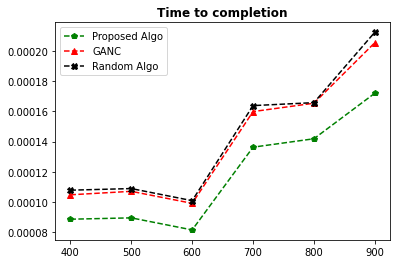

In [ ]:
plt.plot(x, prop_val, label="Proposed Algo", linestyle= 'dashed', color='green',
         marker='p')

plt.plot(x, ganc_val, label="GANC", linestyle= 'dashed', color='red',
         marker='^')

plt.plot(x, rand_val, label="Random Algo", linestyle= 'dashed', color='black',
         marker='X')

plt.title("Time to completion", fontweight='bold')
plt.legend()
plt.show()

### Wait time graph

In [ ]:
x = list(wait_results.keys())
y = list(wait_results.values())

prop_val = []
ganc_val = []
rand_val = []

for temp in y:
  prop_val.append(temp[0])
  ganc_val.append(temp[1])
  rand_val.append(temp[2])

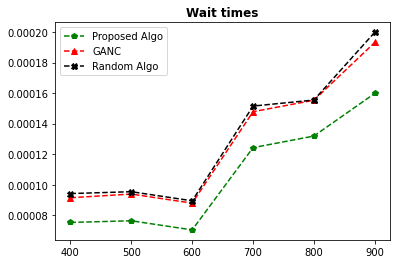

In [ ]:
plt.plot(x, prop_val, label="Proposed Algo", linestyle= 'dashed', color='green',
         marker='p')

plt.plot(x, ganc_val, label="GANC", linestyle= 'dashed', color='red',
         marker='^')

plt.plot(x, rand_val, label="Random Algo", linestyle= 'dashed', color='black',
         marker='X')

plt.title("Wait times", fontweight='bold')
plt.legend()
plt.show()